
# Mass matrices in Hamiltonian Monte Carlo

Importing all needed libraries


In [6]:
%matplotlib notebook

import math
import matplotlib

import numpy as np
from numpy.linalg import inv

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
from scipy.misc import derivative

mpl.rcParams['font.size'] = 16

Defining the regular grid on which we'll be working

In [141]:
m1 = np.linspace(0,10,41)
m2 = np.linspace(0,10,51)
m1, m2 = np.meshgrid(m1,m2)

# This is a neat little trick that allows us to do really fast numpy stuff! Creating stacks of vectors allows
# us to perform matrix-vector operations on the last two dimensions of ND objects.
m_grid = np.stack((m1,m2))
m_grid = np.expand_dims(m_grid, axis=1)

# The stack option only stacks in the wrong order, no problem though for numpy!
m_grid = np.swapaxes(m_grid, 0, 2)
m_grid = np.swapaxes(m_grid, 1, 3)
del(m1, m2) # <- be nice to Python for once!

Defining our simple and exotic misfit functions

In [92]:
def misfit_multivariate_gaussian(m, invCovariance, mu):
    if m.ndim == 4:
        return np.squeeze(0.5 * np.matmul((m - mu).transpose(0,1,3,2), np.matmul(invCovariance, m - mu)))
    else:
        return np.squeeze(0.5 * np.matmul((m - mu).transpose(1,0), np.matmul(invCovariance, m - mu)))
    
def gradient_misfit_multivariate_gaussian(m, invCovariance, mu):
    return np.matmul(invCovariance, m - mu)
        
def misfitQ_comp(V):
    m1 = V[0]
    m2 = V[1]
    return (-np.log(np.exp(- ((m1-3)/1.3)**2 - ((m2-3)/1)**2) + np.exp(- ((m1-7)/1.5)**2  - ((m2-7)/0.6)**2 )))

def partial_derivatives(func, point):
    def wraps_x(x):
        return func((x, point[1,0]))
    
    def wraps_y(y):
        return func((point[0,0], y))
    
    return (derivative(wraps_x, point[0,0], dx = 1e-6), derivative(wraps_y, point[1,0], dx = 1e-6))

def grad_complex(V):    
    m1 = V[0]
    m2 = V[1]
    
    dm1 = np.zeros_like(m1)
    dm2 = np.zeros_like(m2)

    if m1.size > 1:
        for x in range(0, m1.shape[0]):
            for y in range(0, m1.shape[1]):
                dm1_i, dm2_i = partial_derivatives(misfitQ_comp, [m1[x,y], m2[x,y]])
                dm1[x,y] = dm1_i
                dm2[x,y] = dm2_i
    else:
        dm1, dm2 = partial_derivatives(misfitQ_comp, [m1, m2])
            
    return (dm1,dm2)

<IPython.core.display.Javascript object>


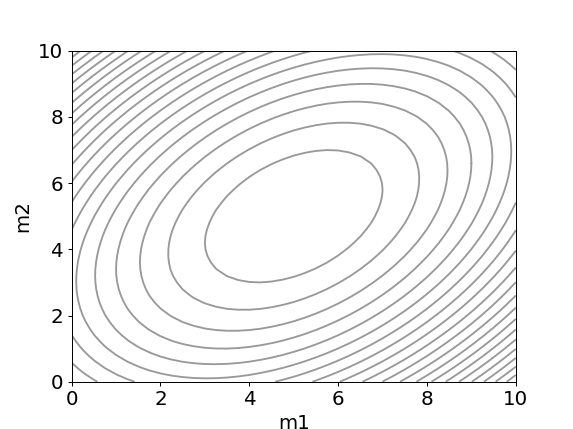

In [142]:
covariance = np.asarray(np.matrix('1.0 0.4; 0.4 1.0'))
means = np.asarray(np.matrix('5; 5'))

X = misfit_multivariate_gaussian(m_grid, inv(covariance), means)
fig = plt.figure()
# ax = Axes3D(fig) 
# surf = ax.plot_surface(m[:,:,0,0], m[:,:,1,0], X, linewidth=0, antialiased=False)
plt.contour(m_grid[:,:,0,0], m_grid[:,:,1,0], X, 20, colors='k', alpha=0.4)
plt.xlabel("m1")
plt.ylabel("m2");

<IPython.core.display.Javascript object>


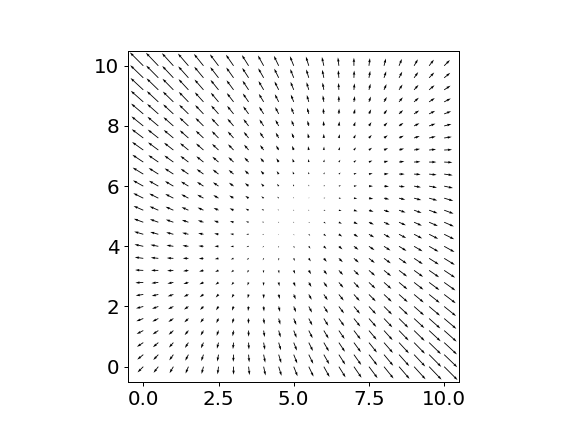

(-0.5, 10.5, -0.5, 10.5)

In [143]:
dm = gradient_misfit_multivariate_gaussian(m_grid, inv(covariance), means)
plt.figure()
stepsize = 2
plt.quiver(m_grid[::stepsize,::stepsize,0,0], 
           m_grid[::stepsize,::stepsize,1,0],
           dm[::stepsize,::stepsize,0,0], 
           dm[::stepsize,::stepsize,1,0])
plt.axis('square')

In [133]:
def integrate(m, p, invMass, invCovariance, means, n, epsilon):
    
    dm = gradient_misfit_multivariate_gaussian(m, invCovariance, means)
    
    # add first location to accumulator
    m_arr = m
    # first half-leapfrog step and add new momentum to accumulator
    p = p - (epsilon / 2) * dm
    p_arr = p
    
    for i in range(n):
        
        # Leapfrog 
        m  = m + epsilon * (invMass @ p)
        dm = gradient_misfit_multivariate_gaussian(m, invCovariance, means)
        p  = p - epsilon * dm
        
        # add to accumulator
        m_arr = np.hstack((m_arr, m))
        p_arr = np.hstack((p_arr, p))
                     
    return m_arr, p_arr
    
def integrate_sloppy(m, p, M, sigma1, zero1, n, epsilon, interval):
    Minv = inv(M)
    
    dm1, dm2 = gradient_misfitQ(m[0], m[1], sigma1, zero1)
    dm = np.vstack((dm1,dm2))
    
    m_arr = m
    p_arr = p
        
    p = p - (epsilon / 2) * dm
    p_arr = np.hstack((p_arr, p))
    
    for i in range(n):
        m = m + epsilon * (Minv @ p)
        m_arr = np.hstack((m_arr, m))
        
        if(i % interval == 0):
            dm = np.vstack(gradient_misfitQ(m[0], m[1], sigma1, zero1))
            
        p = p - epsilon * dm
        p_arr = np.hstack((p_arr, p))
                     
    return m_arr, p_arr

def integrate_complex(m, p, M, n, epsilon):
    Minv = inv(M)

    
    dm1, dm2 = grad_complex((m[0][0],m[1][0]))
    dm = np.vstack((dm1,dm2))
    
    m_arr = m
    p_arr = p
        
    p = p - (epsilon / 2) * dm
    p_arr = np.hstack((p_arr, p))
    
    for i in range(n):
        m = m + epsilon * (Minv @ p)
        m_arr = np.hstack((m_arr, m))
        
        dm = np.vstack(grad_complex((m[0][0],m[1][0])))
        p = p - epsilon * dm
        p_arr = np.hstack((p_arr, p))
                     
    return m_arr, p_arr

Solve Hamilton's Equations

<IPython.core.display.Javascript object>


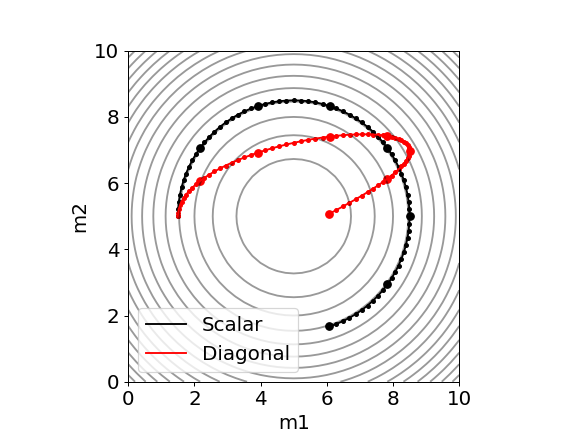

Text(0,0.5,'m2')

In [154]:
# Define posterior Bivariate Normal distribution
covariance = np.asarray(np.matrix('1.0 0; 0 1.0'))
means = np.asarray(np.matrix('5; 5'))

# Starting point for location
m = np.ndarray(shape=(2,1))
m[0] = 1.5
m[1] = 5

# Starting point for momentum
p = np.ndarray(shape=(2,1))
p[0] = 0
p[1] = 3.5

# Create mass matrices
M1 = np.copy(inv(covariance))
M2 = np.copy(M)
M2[1,1] = 2

n = 70
epsilon =  0.02 * math.pi

m_arr1, p_arr1 = integrate(m, p, inv(M1), inv(covariance), means, n, epsilon)
m_arr2, p_arr2 = integrate(m, p, inv(M2), inv(covariance), means, n, epsilon)

plt.figure()

plt.scatter(m_arr1[0,:], m_arr1[1,:], marker='.', color='k')
plt.plot(m_arr1[0,:], m_arr1[1,:], color='k')
plt.scatter(m_arr2[0,:], m_arr2[1,:], marker='.', color='r')
plt.plot(m_arr2[0,:], m_arr2[1,:], color='r')

for i in range(int(n/10)):
    plt.scatter(m_arr1[0,10+i*10], m_arr1[1,10+i*10], marker='o', color='k')
    plt.scatter(m_arr2[0,10+i*10], m_arr2[1,10+i*10], marker='o', color='r')


X = misfit_multivariate_gaussian(m_grid, inv(covariance), means)
plt.contour(m_grid[:,:,0,0], m_grid[:,:,1,0], X, 20, colors='k', alpha=0.4)
plt.xlabel("m1")
plt.ylabel("m2")
plt.axis('square')
plt.legend(['Scalar','Diagonal'], loc='lower left')
plt.xlabel('m1')
plt.ylabel('m2')
# plt.savefig('scalar.30.pdf')

<IPython.core.display.Javascript object>


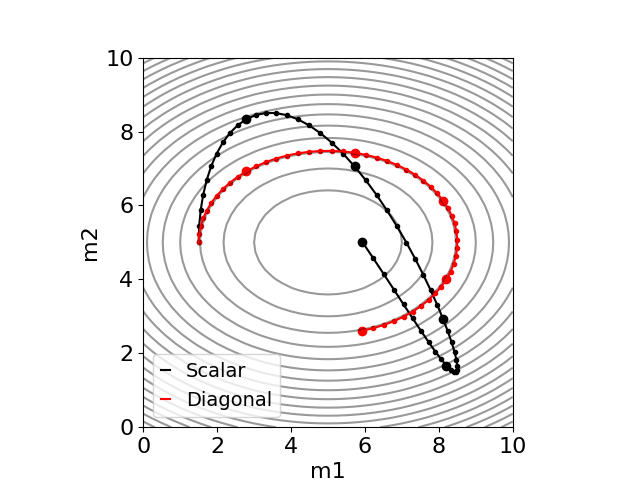

In [33]:
sigma1 = np.matrix('1 0; 0 1')
sigma2 = np.copy(sigma1)
sigma2[1,1] = 2
zero1 = np.matrix('5; 5')

m = np.ndarray(shape=(2,1))
m[0] = 1.5
m[1] = 5

p = np.ndarray(shape=(2,1))
p[0] = 0
p[1] = 7

M = np.ndarray(shape=(2,2))
M[0,0] = 1
M[0,1] = 0
M[1,0] = 0
M[1,1] = 1

M1 = M
M2 = np.copy(M)
M2[1,1] = 2

n = 50
epsilon = 0.02 * math.pi

m_arr1, p_arr1 = integrate(m, p, M1, sigma2, zero1, n, epsilon)
m_arr2, p_arr2 = integrate(m, p, M2, sigma2, zero1, n, epsilon)

plt.figure()

plt.scatter(m_arr1[0,:], m_arr1[1,:], marker='.', color='k')
plt.plot(m_arr1[0,:], m_arr1[1,:], color='k')
plt.scatter(m_arr2[0,:], m_arr2[1,:], marker='.', color='r')
plt.plot(m_arr2[0,:], m_arr2[1,:], color='r')

for i in range(int(n/10)):
    plt.scatter(m_arr1[0,10+i*10], m_arr1[1,10+i*10], marker='o', color='k')
    plt.scatter(m_arr2[0,10+i*10], m_arr2[1,10+i*10], marker='o', color='r')

X = misfitQ(m1, m2, sigma2, zero1)
plt.contour(m1, m2, X, 20, colors='k', alpha=0.4)
#plt.quiver(m1,m2,dm1,dm2)
plt.axis('square')
plt.xlim((0,10))
plt.ylim((0,10))
plt.legend(['Scalar','Diagonal'], loc='lower left')
plt.xlabel('m1')
plt.ylabel('m2')
plt.savefig('diagonal.pdf')

<IPython.core.display.Javascript object>


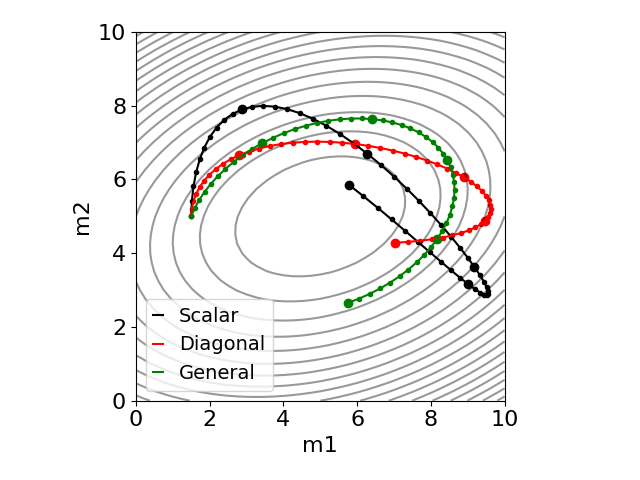

In [34]:
zero1 = np.matrix('5; 5')
r = np.matrix('1 -0.25;-0.25 1') # Correlation matrix
std = np.matrix('1 0;0 1.414')
sigma3 = std @ r @ std

m = np.ndarray(shape=(2,1))
m[0] = 1.5
m[1] = 5

p = np.ndarray(shape=(2,1))
p[0] = 0.1
p[1] = 7

M = np.ndarray(shape=(2,2))
M[0,0] = 1
M[0,1] = 0
M[1,0] = 0
M[1,1] = 1

M1 = M
M2 = np.copy(np.asarray(sigma3))
M2[0,1] = 0
M2[1,0] = 0
M3 = np.asarray(sigma3)

n = 50
epsilon = 0.019 * math.pi

m_arr1, p_arr1 = integrate(m, p, M1, sigma3, zero1, n, epsilon)
m_arr2, p_arr2 = integrate(m, p, M2, sigma3, zero1, n, epsilon)
m_arr3, p_arr3 = integrate(m, p, M3, sigma3, zero1, n, epsilon)

plt.figure()

plt.scatter(m_arr1[0,:], m_arr1[1,:], marker='.', color='k')
plt.plot(m_arr1[0,:], m_arr1[1,:], color='k')
plt.scatter(m_arr2[0,:], m_arr2[1,:], marker='.', color='r')
plt.plot(m_arr2[0,:], m_arr2[1,:], color='r')
plt.scatter(m_arr3[0,:], m_arr3[1,:], marker='.', color='g')
plt.plot(m_arr3[0,:], m_arr3[1,:], color='g')

for i in range(int(n/10)):
    plt.scatter(m_arr1[0,10+i*10], m_arr1[1,10+i*10], marker='o', color='k')
    plt.scatter(m_arr2[0,10+i*10], m_arr2[1,10+i*10], marker='o', color='r')
    plt.scatter(m_arr3[0,10+i*10], m_arr3[1,10+i*10], marker='o', color='g')

X = misfitQ(m1, m2, sigma3, zero1)
plt.contour(m1, m2, X, 20, colors='k', alpha=0.4)
#plt.quiver(m1,m2,dm1,dm2)
plt.axis('square')
plt.xlim((0,10))
plt.ylim((0,10))
plt.legend(['Scalar','Diagonal','General'], loc='lower left')
plt.xlabel('m1')
plt.ylabel('m2')
plt.tight_layout()
plt.savefig('general.pdf')

<IPython.core.display.Javascript object>


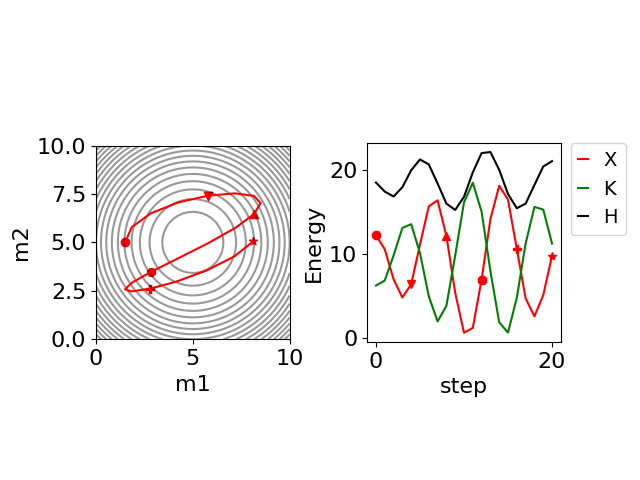

In [35]:
sigma1 = np.matrix('1 0; 0 1')
zero1 = np.matrix('5; 5')

m = np.ndarray(shape=(2,1))
m[0] = 1.5
m[1] = 5

p = np.ndarray(shape=(2,1))
p[0] = 0
p[1] = 5

M = np.ndarray(shape=(2,2))
M[0,0] = 1
M[0,1] = 0
M[1,0] = 0
M[1,1] = 1

M1 = M
M2 = np.copy(M)
M2[1,1] = 2

mult = 4
n = 5 * mult
epsilon = 2 * 0.0002 * math.pi * (1000 / mult)

m_arr1, p_arr1 = integrate(m, p, M1, sigma1, zero1, n, epsilon)
m_arr2, p_arr2 = integrate(m, p, M2, sigma1, zero1, n, epsilon)

fig, ax = plt.subplots(1,3)

#ax[0].scatter(m_arr1[0,:], m_arr1[1,:], marker='.', color='k')
#ax[0].plot(m_arr1[0,:], m_arr1[1,:], color='k')
#ax[0].scatter(m_arr2[0,:], m_arr2[1,:], marker='.', color='r')
ax[0].plot(m_arr2[0,:], m_arr2[1,:], color='r')

markers = ["o","v","^","8","P","*","h","H","+","x"]

X = misfitQ(m1, m2, sigma1, zero1)

ax[0].contour(m1, m2, X, 20, colors='k', alpha=0.4)
#plt.quiver(m1,m2,dm1,dm2)
ax[0].axis('square')
#plt.xlim((0,10))
#ax[0].ylim((0,10))
#ax[0].legend(['Scalar','Diagonal'], loc='lower left')
ax[0].set_xlabel('m1')
ax[0].set_ylabel('m2')

#ax[1].axis('square')
Xtraj = np.squeeze(misfitQ(m_arr2[0,:], m_arr2[1,:], sigma1, zero1))
Xtraj.shape = (n+1,1)
Ktraj = np.squeeze(( (p_arr2[0,:]**2) / (2 * M2[0,0] )  + (p_arr2[1,:]**2) / (2 * M2[1,1]) ))[:-1]
Ktraj.shape = (n+1,1)

ax[1].plot(Xtraj,'r')
ax[1].plot(Ktraj,'g')

ax[1].plot(Ktraj+Xtraj,'k')

for i in range(int(n/mult)+1):
    #ax[0].scatter(m_arr1[0,10+i*10], m_arr1[1,10+i*10], marker='o', color='k')
    ax[0].scatter(m_arr2[0,i*mult], m_arr2[1,i*mult], color='r', marker=markers[i])
    ax[1].plot(i*mult, Xtraj[i*mult], color='r', marker=markers[i])
    
    
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.handlelength'] = 0.5
ax[1].set_xlabel('step')
ax[1].set_ylabel('Energy')
ax[1].set_aspect(2.39 * mult/10)
ax[1].legend(['X', 'K', 'H'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[2].axis('off')

plt.subplots_adjust(left=0.15, bottom=None, right=1.3, top=None, wspace=0.4, hspace=None)
plt.savefig('scalar.Hamiltonian.%isteps.pdf' % n)

<IPython.core.display.Javascript object>


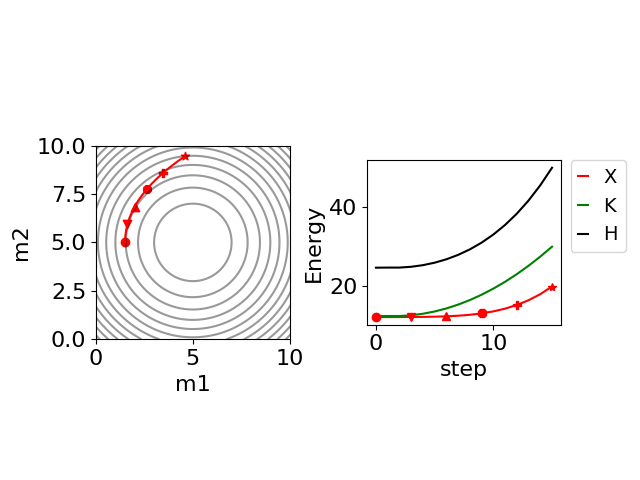

In [58]:
sigma1 = np.matrix('1 0; 0 1')
zero1 = np.matrix('5; 5')

m = np.ndarray(shape=(2,1))
m[0] = 1.5
m[1] = 5

p = np.ndarray(shape=(2,1))
p[0] = 0
p[1] = 5

M = np.ndarray(shape=(2,2))
M[0,0] = 1
M[0,1] = 0
M[1,0] = 0
M[1,1] = 1

M1 = M
M2 = np.copy(M)
M2[1,1] = 1

mult = 3
n = 5 * mult 
epsilon = 2 * 0.0002 * math.pi * 50

interval = 1000
m_arr2, p_arr2 = integrate_sloppy(m, p, M2, sigma1, zero1, n, epsilon, interval)

fig, ax = plt.subplots(1,3)

#ax[0].scatter(m_arr1[0,:], m_arr1[1,:], marker='.', color='k')
#ax[0].plot(m_arr1[0,:], m_arr1[1,:], color='k')
#ax[0].scatter(m_arr2[0,:], m_arr2[1,:], marker='.', color='r')
ax[0].plot(m_arr2[0,:], m_arr2[1,:], color='r')

markers = ["o","v","^","8","P","*","h","H","+","x"]

X = misfitQ(m1, m2, sigma1, zero1)
Y = -7 * m1

ax[0].contour(m1, m2, X, 20, colors='k', alpha=0.4)
#ax[0].contour(m1, m2, Y, 20, colors='k', alpha=0.4)
#plt.quiver(m1,m2,dm1,dm2)
ax[0].axis('square')
ax[0].set_xlim((0,10))
ax[0].set_ylim((0,10))
#ax[0].legend(['Scalar','Diagonal'], loc='lower left')
ax[0].set_xlabel('m1')
ax[0].set_ylabel('m2')

#ax[1].axis('square')
Xtraj = np.squeeze(misfitQ(m_arr2[0,:], m_arr2[1,:], sigma1, zero1))
Xtraj.shape = (n+1,1)
Ktraj = np.squeeze(( (p_arr2[0,:]**2) / (2 * M2[0,0] )  + (p_arr2[1,:]**2) / (2 * M2[1,1]) ))[:-1]
Ktraj.shape = (n+1,1)

ax[1].plot(Xtraj,'r')
ax[1].plot(Ktraj,'g')

ax[1].plot(Ktraj+Xtraj,'k')

for i in range(int(n/mult)+1):
    #ax[0].scatter(m_arr1[0,10+i*10], m_arr1[1,10+i*10], marker='o', color='k')
    ax[0].scatter(m_arr2[0,i*mult], m_arr2[1,i*mult], color='r', marker=markers[i])
    ax[1].plot(i*mult, Xtraj[i*mult], color='r', marker=markers[i])
    
    
    
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.handlelength'] = 0.5
ax[1].set_xlabel('step')
ax[1].set_ylabel('Energy')
ax[1].set_aspect(1.11 * ax[1].get_xlim()[1]/ax[1].get_ylim()[1])
ax[1].legend(['X', 'K', 'H'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[2].axis('off')

plt.subplots_adjust(left=0.15, bottom=None, right=1.3, top=None, wspace=0.4, hspace=None)
plt.savefig('sloppy.pdf')

<IPython.core.display.Javascript object>


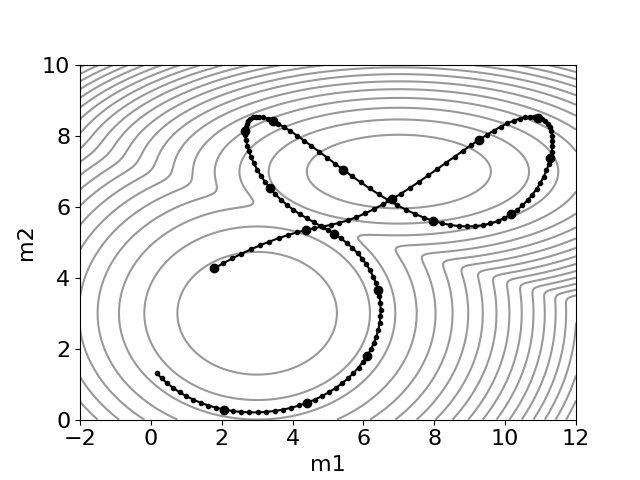

In [37]:
m1 = np.linspace(-2,12,201)
m2 = np.linspace(0,10,201)
m1, m2 = np.meshgrid(m1,m2)

plt.figure()
Y = misfitQ_comp((m1, m2))
plt.contour(m1,m2,Y,20, colors='k', alpha=0.4)

dm1,dm2 = grad_complex((m1,m2))
q_int = 2
#plt.quiver(m1[::q_int,::q_int],m2[::q_int,::q_int],dm1[::q_int,::q_int],dm2[::q_int,::q_int])

plt.axis('square')

m = np.ndarray(shape=(2,1))
m[0] = 0.16
m[1] = 1.31

p = np.ndarray(shape=(2,1))
p[0] = 2.2
p[1] = -4.1

M = np.ndarray(shape=(2,2))
M[0,0] = 1
M[0,1] = 0
M[1,0] = 0
M[1,1] = 1.3**2

M1 = M

n = 170
epsilon =  0.02 * math.pi

m_arr1, p_arr1 = integrate_complex(m, p, M1, n, epsilon)

plt.scatter(m_arr1[0,:], m_arr1[1,:], marker='.', color='k')
plt.plot(m_arr1[0,:], m_arr1[1,:], color='k')

for i in range(int(n/10)):
    plt.scatter(m_arr1[0,10+i*10], m_arr1[1,10+i*10], marker='o', color='k')

#plt.quiver(m1,m2,dm1,dm2)
plt.axis('square')
plt.xlim((-2,12))
plt.ylim((0,10))
#plt.legend(['Scalar','Diagonal'], loc='lower left')
plt.xlabel('m1')
plt.ylabel('m2');
plt.savefig('locally_optimal.pdf')